# Animation demonstrating Gestalt's Principle
----
Reference: (Lonsdale et. al., 2013, http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0062726#s4)  
With reference to the above publication, we shall produce data that correspond to the expected behaviour of CSA signals when exposed to growing bacteria in a petridish. We will then produce animations to visualise these data. 



In [554]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

%matplotlib inline
plt.rcParams['animation.html'] = 'html5'

---
## Manually generating trajectories 
##### (ignore this section if you don't want to know where the data come from. It's messy anyway. )
---
We shall generate the trajectories using the sigmoidal function 
$$ 
\frac{1}{1 + e^{-x}}
$$
with different x and y dilation or shifts in each of the R, G, and B component. 

In [410]:
# A hundred time points. 
time = np.arange(0, 100)

# First set of 3 trajectories
red_func = lambda t: 0.1 * np.ones(len(t))
green_func = lambda t : 0.9 * sigmoid(0.3 * (t - 50))
blue_func = lambda t : 0.9 - 0.8 * sigmoid(0.5 * (t - 40))
curve1 = np.array([red_func(time), green_func(time), blue_func(time)]).transpose()
curve2 = np.array([red_func(time) + 0.01, green_func(time) + 0.01, blue_func(time)]).transpose()
curve3 = np.array([red_func(time) - 0.02, green_func(time), blue_func(time) * 0.5]).transpose()

# second set of 3 trajectories. 
red_func2 = lambda t: 0.8 * sigmoid(0.7 * (np.clip(t, 0, 60) - 20))
green_func2 = lambda t: 0.01 * np.ones(len(t)) + sigmoid((t - 40) * 5) * 0.5 * sigmoid(0.4 * (t - 60))
blue_func2 = lambda t: 0.9 * sigmoid(0.3 * (t - 30)) - sigmoid((t - 40) * 4) * 0.6 * sigmoid(0.5 * (t - 60))
curve4 = np.array([red_func2(time), green_func2(time), blue_func2(time)]).transpose()
curve5 = np.array([red_func2(time), green_func2(time), blue_func2(time) * 0.8]).transpose()
curve6 = np.array([red_func2(time), 0.01 * np.ones(len(time)) + 0.1, 0.9 * sigmoid(0.3 * (time - 30))]).transpose()


# third set of 3 trajectories. They have the same starting point as the first set
# but they differ in "fate"
red_func3 = lambda t: 0.1 * np.ones(len(t)) + 0.5 * sigmoid(0.5 * (t - 50))
green_func3 = lambda t : 0.9 * sigmoid(0.3 * (t - 50))
blue_func3 = lambda t : 0.9 - 0.2 * sigmoid(0.5 * (t - 40))
curve7 = np.array([red_func3(time) + 0.01, green_func3(time), blue_func3(time) - 0.1]).transpose()
curve8 = np.array([red_func3(time), green_func3(time * 0.99), blue_func3(time)]).transpose()
curve9 = np.array([red_func3(time) + 0.1, green_func3(time), blue_func3(time)]).transpose()


# A 9 x 100 x 3 array
all_curves = np.array([curve1, curve2, curve3, curve4, curve5, curve6, curve7, curve8, curve9])

---
And this is how the trajectories looks like together. 

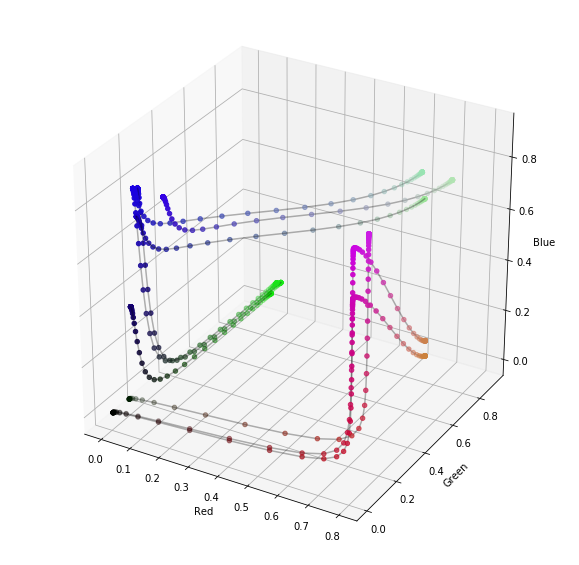

In [497]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("Red")
ax.set_ylabel("Green")
ax.set_zlabel("Blue")

for curve in all_curves:
    ax.scatter3D(xs=curve[:, 0], ys=curve[:, 1], zs=curve[:, 2], c = curve)
    ax.plot3D(curve[:, 0], curve[:, 1], zs = curve[:, 2], alpha=0.3, color='black')

---
### Saving as CSV file
---
The format is as follow: 

 - Each row correspond to a time point
 - Each column is a single color channel of a particular trajectory in the following order: 
    - [R1, G1, B1, R2, G2, ..., B8, R9, G9, B9]

In [493]:
df = pd.DataFrame(all_curves.transpose((0, 2, 1)).reshape(27, 100).transpose())
df.to_csv("./color_space_trajectories.csv", index=False)

## Animation
----
Reference: http://matplotlib.org/api/animation_api.html  
We shall produce animations of the spots moving in the RGB color space while leaving an imprint of their trajectories. Here we use Matplotlib's `animation.FuncAnimation` function to produce our animation. The main input to this function is *another* function which takes as its first argument a whole number that counts the `frame`.  

Here is a quick example of how to use this function. We shall animate a simple sine wave. 

In [533]:
%%time
num_frames = 30
min_time, max_time = 0, 10 * np.pi
t_vals = np.linspace(min_time, max_time, 1000)

# The input frame drawing function for FuncAnimation
def test_anim_func(frame_i, other_args=None):
    line.set_data(t_vals, np.sin((t_vals - frame_i)))
    return line

# Create a figure object as container and an axis where the motion take place
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim((-1.1, 1.1))
ax.set_xlim(min_time, max_time)
# put in the first first frame to obtain the object to update
line = ax.plot(t_vals, np.sin(t_vals))[0]

test_animation = animation.FuncAnimation(fig, test_anim_func,
                                         frames=num_frames,  # Total number of frames (number of time calling func)
                                         fargs=None,         # other arguments for test_anim_func aside from the first
                                         interval=100)       # time interval (centisecond) between frames

# Uncomment to save. 
#test_animation.save("test_ani1.mp4")
plt.close()

CPU times: user 86.4 ms, sys: 3.49 ms, total: 89.8 ms
Wall time: 92.9 ms


In [530]:
HTML(test_animation.to_html5_video())

---
## Now we shall animate our trajectories
---
RGB space is a 3D space. So we need matplotlib 3D plotting facility which is provided in 
` mpl_toolkits.mplot3d.Axes3D `. 


### Step 1:  Reading in the files
---
It's a comma separated file. We shall use a quick plot to look at the time series of each color channels (3 color channels per trajectory). 

,R1,G1,B1,R2,G2,B2,R3,G3,B3,R4,...,B6,R7,G7,B7,R8,G8,B8,R9,G9,B9
0,0.1,2.753120e-07,0.9,0.11,0.010000,0.9,0.08,2.753120e-07,0.45,6.652224e-07,...,0.000111,0.11,2.753120e-07,0.8,0.1,2.753120e-07,0.9,0.2,2.753120e-07,0.9
1,0.1,3.716323e-07,0.9,0.11,0.010000,0.9,0.08,3.716323e-07,0.45,1.339592e-06,...,0.000150,0.11,3.716323e-07,0.8,0.1,3.705191e-07,0.9,0.2,3.716323e-07,0.9
2,0.1,5.016511e-07,0.9,0.11,0.010001,0.9,0.08,5.016511e-07,0.45,2.697603e-06,...,0.000202,0.11,5.016511e-07,0.8,0.1,4.986502e-07,0.9,0.2,5.016511e-07,0.9
3,0.1,6.771580e-07,0.9,0.11,0.010001,0.9,0.08,6.771580e-07,0.45,5.432287e-06,...,0.000273,0.11,6.771580e-07,0.8,0.1,6.710909e-07,0.9,0.2,6.771580e-07,0.9
4,0.1,9.140674e-07,0.9,0.11,0.010001,0.9,0.08,9.140674e-07,0.45,1.093921e-05,...,0.000369,0.11,9.140674e-07,0.8,0.1,9.031641e-07,0.9,0.2,9.140674e-07,0.9


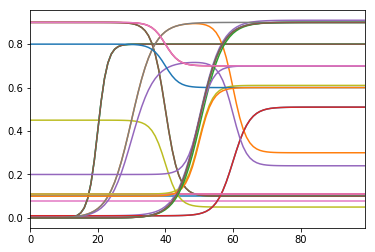

In [536]:
trajectories_df = pd.read_csv("./color_space_trajectories.csv")
trajectories_df.plot(legend=False)
trajectories_df.head()

---
### Step 2: The frame drawing function
---
There will be 3 component to this animation:
  
  1. The position of the moving point which changes in RGB space;
  2. The colour of point which correspond the the RGB color of its position;
  3. The trajectory which will be realised as a line passing through each position the point visited. 

We shall also add in a timer. So in each frame, we need to:

  1. Add in the new spot in the scatter plot where the point next visit
  2. With the correct color
  3. Redraw the trajectory of from the begining up to this time point.

and all these are done on every trajectory that we wish to trace. 

In [599]:
# Text template for the timer. 
TIME_INTERVAL = 20
TIME_TEMPLATE = "%.1f min"
TIME_FONTSIZE = 20
def animate_parametric_curves(frame_i, ax, curves, lines, time_text):
    ax.collections.clear()
    for i, coords in enumerate(curves): # for each trajectory 
        # Redrawing trajectory up to current time point. 
        line = lines[i]
        line.set_data(coords[:frame_i, 0], coords[:frame_i, 1]) # x and y coord
        line.set_3d_properties(coords[:frame_i, 2]) # z coord
        
        
        # Then we plot the (frame_i)th coordinate of the current curve 
        # and give it the correct colour
        ax.scatter3D(coords[:frame_i, 0], coords[:frame_i, 1], coords[:frame_i, 2], 
                     c = coords[:frame_i])
    # Update the timer
    time_text.set_text(TIME_TEMPLATE % (frame_i * TIME_INTERVAL))
    return ax

---
### Finally:
---

In [545]:
[trajectories_df.loc[:, "R{0} G{0} B{0}".format(spot_num).split(' ')] for spot_num in range(1, 10)]

[100, 100, 100, 100, 100, 100, 100, 100, 100]

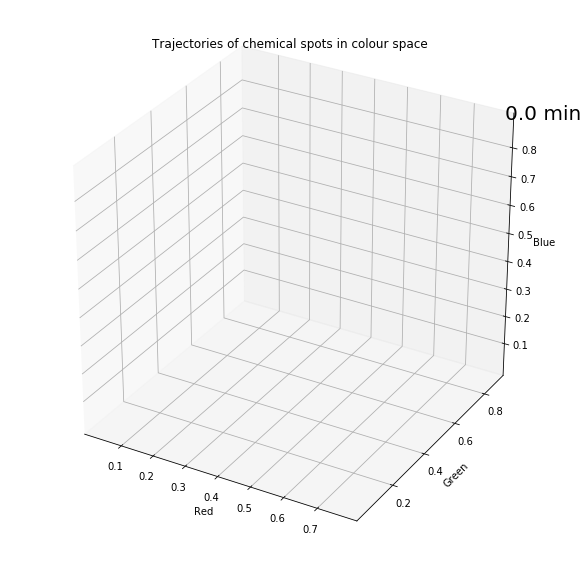

In [602]:
#%%time 

# collecting the curves into an array of shape
# (num_trajectory x num_time_points x num_color_channels)

curves = np.array([np.array(trajectories_df.loc[:, "R{0} G{0} B{0}".format(spot_num).split(' ')])
                   for spot_num in range(1, 10)])

# Tell matplotlib that this is going to be 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# We set the volume (via the x, y, z limit) of the plot to be max and min values in each color channels.
ax.set_xlim((curves[:, :, 0].min(), curves[:, :, 0].max()))
ax.set_ylim((curves[:, :, 1].min(), curves[:, :, 1].max()))
ax.set_zlim((curves[:, :, 2].min(), curves[:, :, 2].max()))
# Axis labels
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
ax.set_title("Trajectories of chemical spots in colour space")

# We will put the timer text at the upper, right, front octant.
time_template = 'time = %.1f min'
time_text = ax.text3D(ax.get_xlim3d()[-1], 
                      ax.get_ylim3d()[-1], 
                      ax.get_zlim3d()[-1],
                      '',
                      size=TIME_FONTSIZE)

# These are the lines that we will be updating.
lines = [ax.plot3D(coords[0:1, 0], coords[0:1, 1], coords[0:1, 2],
                   lw=0.5, alpha=0.5, color='black')[0] 
         for coords in curves]
#scatter = [ax.scatter3D(coords[0, 0], coords[0, 1], coords[0, 2], 
#                     c = coords[0])]


# And now we animate
ani = animation.FuncAnimation(fig, animate_parametric_curves, 
                              frames=curves.shape[1], 
                              fargs=(ax, curves, lines, time_text), 
                              interval=100)
ani.save('test_animation1.mp4')

In [603]:
ani

In [431]:
HTML(ani.to_html5_video())

---
## Some interpretation of this animation
---
  - The animation give a further dimension to the visualisation: Time. This, I think, is a dimension that the mind grasp well intuitively. The delay in response is clear from the animation. 
  - The "volume" of the trajectory, i.e. the smallest coordinate cube containing the entire trajectory is a good measure of "responsiveness". 
  - The colour change (from start to end) also measure this "responsiveness". 
  - The distance between successive point and the change of direction is the rate of change of colour at that time point. 
     - Clusters of spots close together indicate some kind of equilibrium or inactivity. 
  - The "fate" of trajectories of the same species is clear from the plot. 
  - Intra-species difference in fate is small compare to inter-species difference. 

## Another visualisation
---
We can visualise and compare the trajectories in a single image too.  
In all images, the vertical axis is time, which increases downwards.  
In the first image, the we can see the color at each time point of each trajectory.  
In the second image, we substracted from the image the color of the first time point to see the "change" in colour.  
In the third image, we visualise the intensity of *each color channel* as a heat map. 

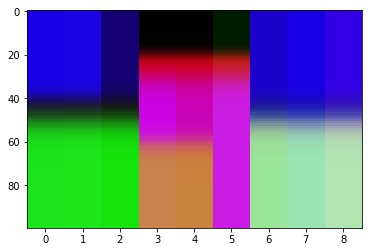

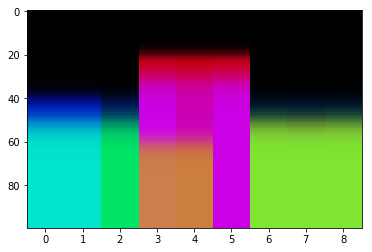

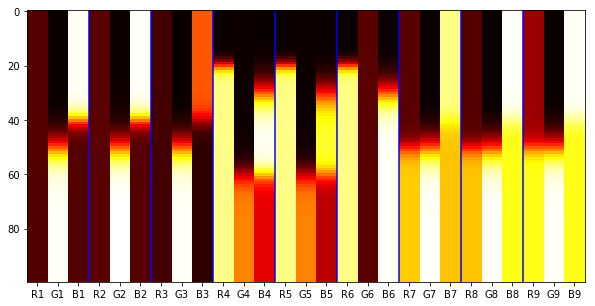

In [581]:
img = curves.transpose((1, 0, 2))
plt.imshow(img, aspect='auto')

plt.figure()
img_diff = np.abs(img - img[0])
plt.imshow(img_diff, aspect='auto')

img_channels = img.reshape(100, 27)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(img_channels, aspect='auto', cmap='hot')
ymin, ymax = ax.get_ylim()
ax.vlines(x = np.arange(2.5, 24, 3), ymin=ymin, ymax=ymax, colors='blue')
plt.xticks(np.arange(0, 27, 1), trajectories_df.columns);

---
## Some other interesting curves
---

---
# IGNORE EVERYTHING BELOW (exploratory codes)
---

In [ ]:
for coord in curve:
    ax.scatter(*coord, c=coord)
ax.plot3D(curve[:, 0], curve[:, 1], zs = curve[:, 2], alpha=0.3, color='black')
    
for coord in curve2:
    ax.scatter(*coord, c=coord)
ax.plot3D(curve[:, 0], curve[:, 1], zs = curve2[:, 2], alpha=0.3, color='black')


for coord in curve3:
    ax.scatter(*coord, c=coord)
ax.plot3D(curve[:, 0], curve[:, 1], zs = curve3[:, 2], alpha=0.3, color='black')

    
for coord in curve4:
    ax.scatter(*coord, c=coord)
ax.plot3D(curve[:, 0], curve[:, 1], zs = curve4[:, 2], alpha=0.3, color='black')


for coord in curve5:
    ax.scatter(*coord, c=coord)
ax.plot3D(curve[:, 0], curve[:, 1], zs = curve5[:, 2], alpha=0.3, color='black')


for coord in curve6:
    ax.scatter(*coord, c=coord)
ax.plot3D(curve[:, 0], curve[:, 1], zs = curve6[:, 2], alpha=0.3, color='black')


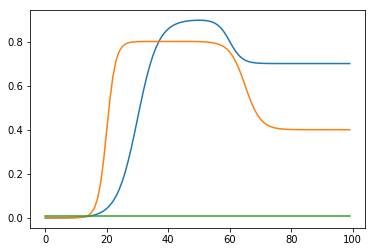

In [305]:
plt.plot(blue_func2(time))
plt.plot(red_func2(time))
plt.plot(green_func2(time))
#plt.plot(sigmoid((time - 60) * 3))

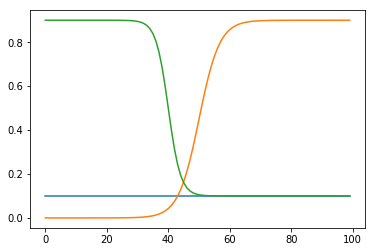

In [278]:
plt.plot(time, red_func(time))
plt.plot(time, green_func(time))
plt.plot(time, blue_func(time))

In [79]:
options =[lambda t: np.ones(len(t)) * np.random.rand(),
          lambda t: -0.8 * sigmoid(t - EXPT_DURATION / 2.0) + 1, 
          lambda t: 0.7 * sigmoid(np.clip(t, 0, EXPT_DURATION * 0.4) + EXPT_DURATION / 2) + \
          heaviside(t - EXPT_DURATION * 0.8),
          lambda t: np.clip(t, 0, EXPT_DURATION * 0.4) ** 2 / (EXPT_DURATION * 0.4)**2, 
          lambda t: t / EXPT_DURATION, 
          lambda t: sigmoid(2 * (t + EXPT_DURATION * 0.6))]


signature = get_species_signature(num_options=len(options))
df = pd.DataFrame(index=time_stamps, columns=columns)
time = np.arange(0, EXPT_DURATION, EXPT_TIME_INTERVAL)
for i, col in enumerate(df.columns):
    signal_func = options[signature[i]]
    df.loc[:, col] = signal_func(time)
    
    
    

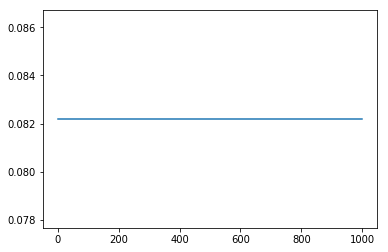

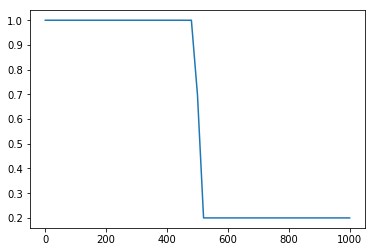

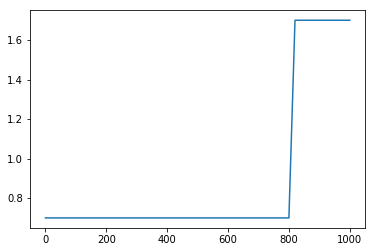

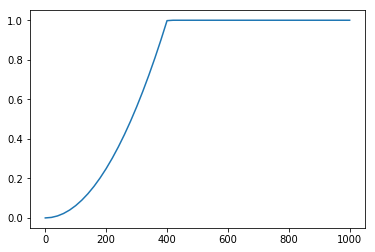

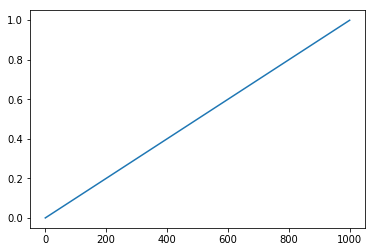

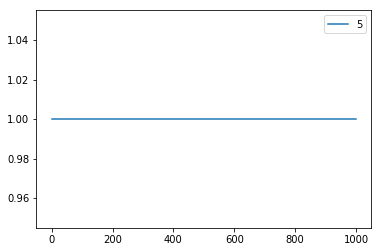

In [80]:
for i, func in enumerate(options):
    plt.figure()
    plt.plot(time, func(time), label=i)
plt.legend()

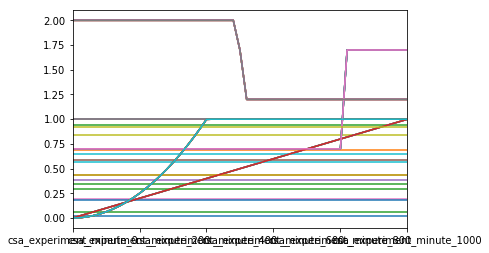

In [74]:
df.plot(legend=False)

In [421]:
from matplotlib import rc
rc('animation', html='html5')
ani

KeyboardInterrupt: 

In [423]:
x = all_curves.copy()

In [445]:
print(x.shape)
y = x.transpose((2, 1, 0)).reshape(27, 100).transpose()
y.shape

(9, 100, 3)


(100, 27)

In [469]:
y = x.transpose((0, 2, 1)).reshape(27, 100).transpose()

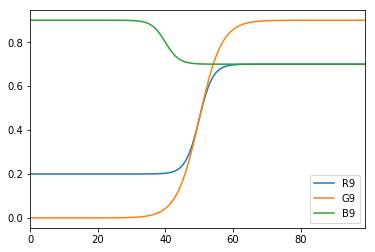

In [475]:
df = pd.DataFrame(y, columns=['%s%i' % (rgb, num) for num in range(1, 10) for rgb in "RGB"])
df.loc[:, ["R9", "G9", "B9"]].plot()

In [477]:
df.to_csv("./color_space_trajectories.csv", index=False)

In [35]:
# GLOBAL CONSTANTS
NUM_CHEM_SPOTS = 20
EXPT_DURATION = 1001 # minutes
EXPT_TIME_INTERVAL = 20
COLOR_CHANNELS = ['R', 'G', 'B']
TIME_STAMP_TEMPLATE = "csa_experiment_minute_%s"


columns = ["%s%i" % (c, num) for num in range(1, NUM_CHEM_SPOTS +1) for c in COLOR_CHANNELS]
time_stamps = [TIME_STAMP_TEMPLATE % minute for minute in range(0, EXPT_DURATION, EXPT_TIME_INTERVAL)]

In [255]:
def sigmoid(t):
    """
    The standard sigmoidal function
    """
    return 1.0 / (1 + np.exp(-t))

def heaviside(x):
    """
    The Heaviside function with jump at x = 0.
    """
    return gaussian_filter1d(np.array(x >= 0.0, dtype=np.int), sigma=2.0)

def get_species_responsive_spots(num_channels=3 * NUM_CHEM_SPOTS):
    """
    Return a random subsequence of the (1, 2, ..., num_channels)
    to be the responsive time series of a species.
    """
    return np.arange(1, num_spots +1, 1)[(np.random.rand(num_spots) > 0.5)]

def get_species_signature(num_channels=3 * NUM_CHEM_SPOTS, num_options=2):
    return np.random.randint(0, num_options, num_channels)

def create_data(active_channels):
    """
    Create a single species level data. 
    """
    return 


def normalise(array):
    return array / (np.max(array) - np.min(array))

In [482]:
(81 + 82 + 73 + 92) / 4

82.0